# Syntax analysis

## Import librairies

In [1]:
#!pip install dkpro-cassis
#!pip install --upgrade spacy
#!pip install spacy
#!pip install spacy-transformers
#!python -m spacy download fr_core_news_md -q
#!python -m spacy download fr_core_news_lg -q
#!python -m spacy download fr_dep_news_trf

In [2]:
import os
import glob
import time
import string
import matplotlib

import networkx

from cassis import *

from lxml import etree

import itertools

import pandas as pd
import re

import spacy
import spacy_transformers
from spacy import displacy
from spacy.matcher import Matcher
#import fr_core_news_md
#nlp = fr_core_news_md.load()
#import fr_core_news_lg
#nlp_lg = fr_core_news_lg.load()
import fr_dep_news_trf
nlp = fr_dep_news_trf.load()

spacy.require_cpu() 

/home/gcortal/anaconda3/envs/M2_syntactic_analysis/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

## Basic functions (lemmatization, tokenization, stemming, etc.)

---



In [3]:
def get_lemma(sentence):
  doc = nlp(sentence)
  return [token.lemma_ for token in doc]

In [4]:
#def get_stem(sentence):
#    if type(sentence) == list:
#      sentence = " ".join(sentence)
#    doc = nlp(sentence)
#    return [stemmer.stem(token.text) for token in doc]

In [5]:
def get_noun_chunk(token):
  noun_chunks = [nc for nc in token.doc.noun_chunks]
  token_chunks = list()
  for tok in token.doc:
      for nc in noun_chunks:
          if tok.i >= nc.start and tok.i < nc.end:
              if token.i == tok.i:
                return nc

In [6]:
# Matcher pour les groupes prépositionnels exprimant des causes

matcher = Matcher(vocab=nlp.vocab)
pattern = [{"LOWER": {"IN": ["à", "a"]}}, {"TEXT": {"IN": ["cause", "force"]}}, {"POS": "ADP"}]
pattern2 = [{"LOWER": "grâce"}, {"POS": "ADP"}]
pattern3 = [{"LOWER": "en"}, {"LOWER": "raison"}, {"POS": "DET"}]
pattern4 = [{"LOWER": "le"}, {"LOWER": "fait"}, {"LOWER": "que"}]
pattern5 = [{"LOWER": "pour"}, {"LOWER": "que"}]
matcher.add("CAUSE_PATTERN", [pattern, pattern2, pattern3, pattern4, pattern5])

## Get French synonyms using WOLF (French WordNet)

In [7]:
wolffile = etree.parse('wolf-1.0b4.xml')
wolfdata = wolffile.getroot()

In [8]:
def get_synonym(word):
  k = 0
  choice = -1
  synonyms = list()
  for synset in wolfdata:
    k = k + 1 
    synonyms_temp = list()
    for literal in synset.find('SYNONYM'):
      synonyms_temp.append(literal.text)
      if literal.text == word:
        choice = k
      if k == choice:
        synonyms = synonyms + synonyms_temp
        synonyms = list(set(synonyms))
      if k > choice and choice != -1:
        break
  return synonyms

In [9]:
def words_to_synonyms(words):
  synonym_dict = dict()
  for word in words:
    synonym_dict[word] = get_synonym(word)
  return synonym_dict

In [10]:
def get_synonyms(words):
  synonym_dict = words_to_synonyms(words)
  return list(set(itertools.chain.from_iterable(list(synonym_dict.values()))))

In [11]:
def get_synonyms(words, depth=1, banned_words=list()):
  synonyms = list()
  for i in range(depth):
    words = list(set(synonyms + words))
    synonym_dict = words_to_synonyms(words)
    synonyms = list(set(itertools.chain.from_iterable(list(synonym_dict.values()))))
    synonyms = remove_synonyms(synonyms, banned_words)
    print(synonyms)
  return synonyms

In [12]:
def remove_synonyms(all_synonyms, banned_synonyms):
  return list(set(all_synonyms) - set(banned_synonyms))

In [13]:
emotion_synonyms = get_synonyms(["pleur", "pleurer", "agacement", "colère", "joie", "tristesse", "peur", "craindre", "mauvais", "bonheur", "agréable", "plaisant", "heureux", "content", "infâme", "horrible", "nul", "insulter", "empirer"], depth=1, banned_words=["notoire", "contenu", "risqué", "ira", "ire", "spéculatif", "épine", "zéro"])

['effroi', 'amertume', 'épouvantable', 'difficile', 'mal', 'malheur', 'abominable', 'nul', 'abject', 'bonheur', 'détestable', 'honnir', 'plaisir', 'craindre', 'pleur', 'rancune', 'drôle', 'joie', 'affreux', 'odieux', 'hideux', 'ressentiment', 'colère', 'heureux', 'mauvais', 'fameux', 'atroce', 'indignation', 'rancœur', 'félicité', 'horrible', 'calomnier', 'larme', 'repoussant', 'crainte', 'agréable', 'plaisant', 'satisfait', 'redouter', 'féroce', 'diffamer', 'soucier', 'pleurer', 'fureur', 'allégresse', 'répugnant', 'insulter', 'irritation', 'agacement', 'épouvante', 'empirer', 'peur', 'infâme', 'tort', 'content', 'tristesse', 'gai', 'euphorique']


In [14]:
attaque_synonyms = get_synonyms(["attaquer", "agresser", "moquer"], depth=2, banned_words=["prendre", "neiger"])

['contester', 'agresser', 'embrouiller', 'attaquer', 'moquer']
['défendre', 'rejeter', 'contester', 'emmêler', 'agresser', 'embrouiller', 'perturber', 'réfuter', 'attaquer', 'protéger', 'moquer']


In [15]:
emotion_synonyms = get_lemma(" ".join(emotion_synonyms))
attaque_synonyms = get_lemma(" ".join(attaque_synonyms))
temp = list()
for synonym in attaque_synonyms:
    synonym = synonym[:-1]
    temp.append(synonym)
attaque_synonyms = attaque_synonyms + temp

/home/gcortal/anaconda3/envs/M2_syntactic_analysis/lib/python3.7/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [16]:
#emotion_synonyms_stem = [get_stem(synonym)[0] for synonym in emotion_synonyms]
#attaque_synonyms_stem = [get_stem(synonym)[0] for synonym in attaque_synonyms]

## SpaCy: define new Token attributes



In [17]:
def isHumain(token):
    #if re.search(r"PronType=Prs", token.tag_) and re.search(r"Person=3", token.tag_) and token._.is_cause:
    # re.search(r"^(il|elle)(s)*$", token.text.lower())
    if token._.is_cause and (token.morph.get("PronType") == ['Prs'] or token.pos_ == "PRON") and token.morph.get("Person") == ["3"]:
    #if token._.is_cause and re.search(r"PronType=Prs", token.tag_) and re.search(r"Person=3", token.tag_):
      return True
    else:
      return False

In [18]:
def isTerritoire(token, attaque_synonyms):

  # [Ma grande confiance] a été attaqué | Il attaque [ma confiance]

  # L'objet de l'attaque (et ses synonymes) à la voie active ou le sujet à la voie passive

  # Si attaque est au participe présent ? 

  #if token.pos_ == "NOUN" and token.head.pos_ == "VERB" and (token.dep_ == "nsubj:pass" or token.dep_ == "obj" or token.dep_ == "obl") and (get_stem(token.head.text)[0] in get_stem(attaque_synonyms)):
  #if token.pos_ == "NOUN" and token.head.pos_ == "VERB" and (token.dep_ == "nsubj:pass" or token.dep_ == "obj") and (get_stem(token.head.text)[0] in attaque_synonyms_stem):
  if token.pos_ == "NOUN" and token.head.pos_ == "VERB" and (token.dep_ == "nsubj:pass" or token.dep_ == "obj") and token.head.lemma_ in attaque_synonyms:
    return True
  else:
    return False

In [19]:
def isCauseAttaque(token, attaque_synonyms): # TO BE DELETED

  # [Il] attaque ma confiance

  # Le sujet de l'attaque (et ses synonymes). Le mot attaque (et ses synonymes). 
  # Si le sujet est un pronom, alors c'est une entité humaine

  # TODO: Distinguer cause humaine/non humaine, cause abstraite/concrète
  # 

  if token.dep_ == "nsubj" and token.head.pos_ == "VERB" and token.head.lemma_ in attaque_synonyms:
    return True
  elif token.head.lemma_ in attaque_synonyms:
    return True 
  else:
    return False

In [20]:
def isModifieur(token):

  # Il est [très] chiant

  # Un adverbe ou un adjectif qui modifie un adjectif, un nom ou un verbe marqué comme INDICE
  
  if (token.pos_ == "ADV" or token.pos_ == "ADJ") and (token.head.pos_ == "ADJ" or token.head.pos_ == "NOUN" or token.head.pos_ == "VERB") and (token.dep_ == "advmod" or token.dep_ == "amod") and token.head._.is_indice: #and token.text in synonyms 
    return True
  else:
    return False

In [21]:
def isIndice(token, emotion_synonyms):

  # Les synonymes de peur, colère, tristesse et joie (ces derniers sont inclus). 

  return (token.lemma_ in emotion_synonyms)

In [22]:
def isAuteur(token):

  # Les pronoms personnels et les pronoms possessifs au singulier comme "me", "ma", "mienne", etc.
  # Les pronoms personnels et les pronoms possessifs au pluriel comme "nous", "notre", "nos", etc.
  # L'attribut "plus" vaut dans ce cas True

  if re.search(r"^(me|ma|mon|mes|m|je|j|mienne|miennes|mien|miens|moi)('|’)*$", token.text.lower()):
    return True
  elif re.search(r"^(notre|nôtre|nous|nos)(s)*$", token.text.lower()):
    token._.is_plus = True
    return True
  else:
    return False

In [23]:
def applyCible(doc):

  # Un pronom oblique qui est la cible d'une attaque

  for token in doc:
    if isCauseAttaque(token, attaque_synonyms_stem):
      for children in token.children:
        if children.pos_ == "PRON" and (children.dep_ == "obl" or children.dep_ == "nsubj:pass"):
          for t in children.subtree:
            t._.is_cible = True

In [24]:
# Les propositions indépendantes et subordonnées de cause dans une phrase comportant une INDICE
# Répète le mot marquant la cause l'annote avec ses enfants

# Les propositions indépendantes comme "Nous sortirons [!car! il fait beau]"
# Les propositions subordonnées de cause comme les locutions conjonctives (parce que, vu que, etc.) ou les conjonctions (puisque, comme)

# TODO: Les groupes prépositionnels. Il est introduit par les locutions prépositives : à cause de(du), en raison de (du), grâce à,  à force de + nom. Ou bien par la préposition pour + nom.

def applyCause(doc, matcher, attaque_synonyms):

  for token in doc:
    if token.lemma_ in attaque_synonyms and token.pos_ == "VERB":
      token._.is_cause = True
      for child in token.children:
        if child.dep_ == "nsubj":
          child._.is_cause = True
        #if child.dep_ == "nsubj:pass":
          #child._.is_cible = True
        #if child.pos_ == "NOUN" and child.dep_ == "obl": # MD
        if child.pos_ == "NOUN" and (child.dep_ == "obl:mod" or child.dep_ == "obl:agent"): # TRF
          for t in child.subtree:
            t._.is_cause = True


  for sent in doc.sents:
    indice = False
    for token in sent:
      if token._.is_indice:
        indice = True
    
    for token in sent:
      
      if (token.pos_ == "CCONJ" or token.pos_ == "SCONJ") and (token.text.lower() in ["car", "puisque", "puisqu'", "lorsque", "lorsqu'", "parce", "comme"]) and indice: #(token.text in ["car", "puisque", "puisqu'", "lorsque", "lorsqu'", "parce", "comme"])
        max = token.head.i
        for c in token.head.children:
          if max < c.i:
            max = c.i
        for t in doc[token.i:max+1]:
          #t._.is_cause = True
          t._.is_aspect = True


      if token.dep_ == "fixed" and token.head.dep_ == "mark" and token.pos_ == "SCONJ" and indice:
        for t in token.head.head.subtree:
          #t._.is_cause = True
          t._.is_aspect = True
      elif token.dep_ == "mark" and token.pos_ == "SCONJ" and indice:
        for t in token.head.subtree:
          #t._.is_cause = True
          t._.is_aspect = True




  matches = matcher(doc)
  
  for match_id, start, end in matches:
      for token in doc[start:end]:
        token._.is_cause = True
      for token in doc[end].subtree:
        token._.is_cause = True

In [25]:
def applyTerritoire(doc, attaque_synonyms):

  # Si un token est annoté comme TERRITOIRE, alors on annote également son groupe nominal ou les enfants à gauche
  # Je me suis agressée [dans ma crédibilité].
  # [Mon sens de la vie] a été agressé 

  # Le territoire attaqué est ... ou Ma confiance attaqué pas pris en compte

  # Groupe nominal contenant le mot attaque et ses synonymes

  for token in doc:
    if token.lemma_ in attaque_synonyms:
      if token.head.pos_ == "NOUN" and token.dep_ == "acl":
        noun_chunk = get_noun_chunk(token.head)
        if noun_chunk != None:
          territoire_word = False
          for t in noun_chunk:
            if t.lemma_ == "territoire":
              territoire_word = True
          if territoire_word == False:
            for t in noun_chunk:
              if t.i == token.i:
                break
              t._.is_territoire = True
  
  for token in doc:
    if isTerritoire(token, attaque_synonyms):
      token._.is_territoire = True    
      noun_chunk = get_noun_chunk(token)
      if noun_chunk == None:
        for t in token.children:
          if t.pos_ == "DET":
            t._.is_territoire = True
        #for child in token.lefts: # Si on prend en compte 
        #  child._.is_territoire = True    
      else:
        for t in noun_chunk:
          t._.is_territoire = True

In [95]:
def applyAspect(doc):

  # Je suis en colère contre [lui]

  #for token in doc:
  #  if token.dep_ == "nmod" and token.head._.is_indice: #Restreindre qu'à la colère et/ou la peur ? 
  #    token._.is_aspect = True

  # J'ai peur [du regard des autres]

  for token in doc:
    if token._.is_indice:
      for child in token.children:
        if child.dep_ == "obl:arg":
          for t in child.subtree:
            t._.is_aspect = True
      for child in token.head.children:
        if child.dep_ == "obl:arg":
          for t in child.subtree:
            t._.is_aspect = True
        
        # Je suis heureuse de voir que je suis à ma place
        
      for child in token.children:
        if child.dep_ == "xcomp":
          for t in child.subtree:
            t._.is_aspect = True
                    
        # La peur de ne pas être à la hauteur
        
      for child in token.children:
        if child.dep_ == "nmod":
          for t in child.subtree:
            t._.is_aspect = True
            
            

        # J'étais contente d'être dans cette pièce
      for child in token.subtree:
        if child.dep_ == "obl:arg":
          for c in child.subtree:
            c._.is_aspect = True
                    
        # J'ai peur d'être viré           
      if token.head.pos_ == "VERB":
        for child in token.head.subtree:
          if child.dep_ == "xcomp":
            for c in child.subtree:
              c._.is_aspect = True

In [96]:
def applyNegation(doc):
    
    # ne/n' ... pas
    for token in doc:
        if token.pos_ == "VERB" or token.pos_ == "NOUN":
            for child in token.children:
                if child.lower_ in ["n'", "ne", "pas"] and child.pos_ == "ADV" and child.dep_ == "advmod":
                    child._.is_negation = True
                    
        # absence, nul, etc.
        if (token.pos_ == "NOUN" or token.pos_ == "DET") and (token.lower_ in ["absence", "aucune"]):
            token._.is_negation = True
            
        # ne/n' ... pas
        if token.morph.get("Polarity") == ["Neg"]:
            token._.is_negation = True

In [97]:
def run_analysis(doc):
  # On peut réduire le temps d'execution (2x plus vite) en stockant les racines des tokens
  for token in doc:
    token._.is_auteur = token._.is_auteur or isAuteur(token)
    token._.is_indice = token._.is_indice or isIndice(token, emotion_synonyms)


  for token in doc:
    #token._.is_cause = token._.is_cause or isCauseAttaque(token, attaque_synonyms_stem)
    token._.is_modifieur = token._.is_modifieur or isModifieur(token)
    
  applyNegation(doc)
  applyCause(doc, matcher, attaque_synonyms)
  applyTerritoire(doc, attaque_synonyms)
  applyAspect(doc)
  #applyCible(doc)

  for token in doc:
    token._.is_humain = token._.is_humain or isHumain(token)

In [98]:
def file_to_doc(f):

  grille = open(filename, 'r')

  sentences = list()
  for line in grille:
    if len(line.strip()) > 0:
      sentence = line.strip()
      if sentence[-1] not in [".", "?", "!"]:
        sentence = sentence + "."
      sentences.append(sentence)

  grille.close()

  text = " ".join(sentences)

  return sentences, nlp(text)

In [99]:
def doc_to_df(doc):

  tokens_info = list()

  for token in doc:
      tokens_info.append([token, str(token.text.lower()), token.lemma_, token.pos_, token.tag_, token.dep_,
              token.shape_, token.is_alpha, token.is_stop, token._.is_auteur, token._.is_plus, token._.is_indice, token._.is_modifieur, token._.is_cause, token._.is_humain, token._.is_territoire, token._.is_cible, token._.is_aspect, token._.is_negation])
      
  df = pd.DataFrame(tokens_info, columns = ['token', 'text_lower', 'lemma', 'pos', 'tag', 'dep', 'shape', 'alpha', 'stop', 'isAuteur', 'isPlus', 'isIndice', 'isModifieur', 'isCause', 'isHumain', 'isTerritoire', 'isCible', 'isAspect', 'isNegation'])

  return df

In [100]:
def export_to_xmi(name, sentences, doc, type_system_filename, groupes):

  SENTENCE_TYPE = "de.tudarmstadt.ukp.dkpro.core.api.segmentation.type.Sentence"
  TOKEN_TYPE = "de.tudarmstadt.ukp.dkpro.core.api.segmentation.type.Token"
  GROUPE_TYPE = "webanno.custom.Groupe" # This is the Internal Name in the layer settings 
  PARTIE_TYPE = "webanno.custom.Partie" # This is the Internal Name in the layer settings 

  with open(type_system_filename, "rb") as f:
    ts = load_typesystem(f)

  cas = Cas(typesystem=ts)
  cas.sofa_string = doc.text

  Sentence = ts.get_type(SENTENCE_TYPE)
  Token = ts.get_type(TOKEN_TYPE)
  Groupe = ts.get_type(GROUPE_TYPE)
  Partie = ts.get_type(PARTIE_TYPE)

  begin = 0
  end = 0
  i = 0

  for sentence in sentences:
    i = i + 1
    end = end + len(sentence)
    cas_sentence = Sentence(begin=begin, end=end)
    cas.add(cas_sentence)
    assert sentence == cas_sentence.get_covered_text()

    if i == 1:
      cas_partie = Partie(begin=begin, end=end, Label = "fait extérieur")
      cas.add(cas_partie)
      assert sentence == cas_partie.get_covered_text()
    elif i == 2:
      cas_partie = Partie(begin=begin, end=end, Label = "fait intérieur")
      cas.add(cas_partie)
      assert sentence == cas_partie.get_covered_text()
    elif i == 3:
      cas_partie = Partie(begin=begin, end=end, Label = "émotion")
      cas.add(cas_partie)
      assert sentence == cas_partie.get_covered_text()
    elif i == 4:
      cas_partie = Partie(begin=begin, end=end, Label = "raison")
      cas.add(cas_partie)
      assert sentence == cas_partie.get_covered_text()
    else:
      raise Exception

    begin = end + 1
    end = end + 1 

  for token in doc:
    cas_token = Token(begin=token.idx, end=token.idx + len(token))
    cas.add(cas_token)
    assert token.text == cas_token.get_covered_text()

  for groupe, tag in groupes:
      cas_groupe = Groupe(begin=groupe.start_char, end=groupe.end_char, Tag = tag)
      cas.add(cas_groupe)
      assert groupe.text == cas_groupe.get_covered_text()

  cas.to_xmi(f"outputs/{name}.xmi")

In [101]:
def delete_punct(span):
    if span[0].lower_ in string.punctuation:
        span = span[1:]
    elif span[-1].lower_ in string.punctuation:
        span = span[:-1]
    return span

In [103]:
def df_to_tags(df):

  groupes = list()
  types = ["CAUSE", "MODIFIEUR", "INDICE", "TERRITOIRE", "PLUS", "HUMAIN", "CIBLE", "AUTEUR", "ASPECT", "NEGATION"]


  for type_groupe in types:
    check = False
    for idx, row in df.iterrows():
      if row[f'is{type_groupe.capitalize()}'] == True and check == False:
        start = row['token'].i
        check = True
      elif row[f'is{type_groupe.capitalize()}'] == False and check == True:
        check = False
        end = row['token'].i
        groupes.append((delete_punct(doc[start:end]), type_groupe))
      if check == True and (len(df) - 1) == idx:
        end = row['token'].i + 1
        groupes.append((delete_punct(doc[start:end]), type_groupe))

  return groupes

In [104]:
from spacy.tokens import Token

Token.set_extension("is_territoire", force=True, default=False)
Token.set_extension("is_auteur", force=True, default=False)
Token.set_extension("is_cause", force=True, default=False)
Token.set_extension("is_indice", force=True, default=False)
Token.set_extension("is_modifieur", force=True, default=False)
Token.set_extension("is_plus", force=True, default=False)
Token.set_extension("is_humain", force=True, default=False)
Token.set_extension("is_cible", force=True, default=False)
Token.set_extension("is_aspect", force=True, default=False)
Token.set_extension("is_negation", force=True, default=False)

## Raw text to INCEpTION's XMI

In [105]:
#!mkdir outputs

In [106]:
#%cd outputs

In [107]:
start_time = time.time()
path = 'grilles'
for filename in glob.glob(os.path.join(path, '*.txt')):
  with open(os.path.join(os.getcwd(), filename), 'r') as f:

    head, name = os.path.split(filename)
    name = re.sub("\.txt", "", name)

    sentences, doc = file_to_doc(filename)
    run_analysis(doc)
    df = doc_to_df(doc)
    groupes = df_to_tags(df)
    print(groupes)
    export_to_xmi(name+"_v3", sentences, doc, "TypeSystem.xml", groupes)

!zip "outputs.zip" -r "outputs"
print("--- %s seconds ---" % (time.time() - start_time))

[(attaqué par la personne qui va à l’encontre du fait que je crois qu’il y ait des règles tacites dans les transports en commun, 'CAUSE'), (colère, 'INDICE'), (nous, 'PLUS'), (il y, 'HUMAIN'), (J’, 'AUTEUR'), (J’, 'AUTEUR'), (j’, 'AUTEUR'), (ma, 'AUTEUR'), (Je m’, 'AUTEUR'), (nous, 'AUTEUR'), (Je, 'AUTEUR'), (j’, 'AUTEUR'), (j’, 'AUTEUR'), (J’, 'AUTEUR'), (Je m’, 'AUTEUR'), (J’, 'AUTEUR'), (moi, 'AUTEUR'), (Je me, 'AUTEUR'), (je, 'AUTEUR'), (J’, 'AUTEUR'), (je, 'AUTEUR'), (n’, 'NEGATION'), (plus, 'NEGATION'), (n’, 'NEGATION'), (ne, 'NEGATION'), (pas, 'NEGATION')]
[(attaqué par mon chef qui veut m’imposer, tout au moins, me rallier, à son sens des priorités, 'CAUSE'), (attaquée, 'CAUSE'), (plutôt, 'MODIFIEUR'), (contente, 'INDICE'), (colère, 'INDICE'), (colère, 'INDICE'), (l’image de moi que j’essaie de lui envoyer aussi, 'TERRITOIRE'), (Nous, 'PLUS'), (notre, 'PLUS'), (nous, 'PLUS'), (nous, 'PLUS'), (nous, 'PLUS'), (mon, 'AUTEUR'), (mon, 'AUTEUR'), (Nous, 'AUTEUR'), (notre, 'AUTEUR'), 

[(pour que tous, 'CAUSE'), (agressée dans ma crédibilité par l’interruption de ce collègue, 'CAUSE'), (difficile, 'INDICE'), (colère, 'INDICE'), (Colère, 'INDICE'), (Peur, 'INDICE'), (colère, 'INDICE'), (nos, 'PLUS'), (Notre, 'PLUS'), (Nous, 'PLUS'), (Nos, 'PLUS'), (j’, 'AUTEUR'), (mes, 'AUTEUR'), (nos, 'AUTEUR'), (J’, 'AUTEUR'), (mon, 'AUTEUR'), (mes, 'AUTEUR'), (ma, 'AUTEUR'), (Notre, 'AUTEUR'), (mon, 'AUTEUR'), (mon, 'AUTEUR'), (me, 'AUTEUR'), (Ma, 'AUTEUR'), (je, 'AUTEUR'), (me, 'AUTEUR'), (me, 'AUTEUR'), (Nous, 'AUTEUR'), (Nos, 'AUTEUR'), (mon, 'AUTEUR'), (Je, 'AUTEUR'), (Je me, 'AUTEUR'), (je, 'AUTEUR'), (moi, 'AUTEUR'), (J’, 'AUTEUR'), (Je me, 'AUTEUR'), (mon, 'AUTEUR'), (mon, 'AUTEUR'), (Je, 'AUTEUR'), (me, 'AUTEUR'), (J’, 'AUTEUR'), (ma, 'AUTEUR'), (Ma, 'AUTEUR'), (me, 'AUTEUR'), (je, 'AUTEUR'), (ma, 'AUTEUR'), (Je me, 'AUTEUR'), (je, 'AUTEUR'), (Je me, 'AUTEUR'), (ma, 'AUTEUR'), (paraître ma colère, 'ASPECT'), (ne, 'NEGATION'), (pas, 'NEGATION'), (ne, 'NEGATION'), (pas, 'NEGA

## Text Analysis

In [90]:
text = "Ma confiance a été attaquée"
text = "Il attaque ma confiance"
text = "J'ai eu très peur ce jour-là, il avait attaqué ma sécurité"
text = "J'ai perdu toute confiance en moi à cause de lui, j'ai peur d'être seul, les gens sont mauvais"
text = "Il m'a attaqué comme il avait peur de moi"
text = "Lorsqu'il m'a attaqué, j'avais très peur"
text = "Le petit garçon pleure parce qu'il a été battu par son frère"
text = "Nous sortirons car il fait beau"
text = "Sous prétexte que leur fils a échoué aux examens, les parents sont déçus"
text = "Il arrivait chaque jour en retard sous prétexte que sa montre retardait"
text = "Pierre a été puni à cause de ses absences"
text = "Grâce à votre aide, nous avons réussi"
text = "Sous prétexte que leur fils a échoué aux examens, les parents sont déçus"
text = "Je me sens agressée dans ma crédibilité par l'interruption de ce collègue. Il me fait très peur."
#text = "Je me suis dit qu'il se moquait de moi car il avait peur"
#text = "J'ai peur d'être viré"
text = "Mon sens de la vie a été agressé"
text = "Estime de moi + sécurité (peur d’être viré) attaqués par ma tutrice et par moi-même"
text = "Il attaque ma capacité à être respecté en classe et ma reconnaissance."
text = "Mon sens du goût attaqué par cette sauce infâme, mes habitudes et la sensation de sécurité qu’elles procurent ont été attaquées ainsi que la connaissance de ce qui m’entoure, la sécurité de la salade tomate-oeuf-sauce que j’ai l’habitude de manger"
text = "Mon sens du goût attaqué par cette sauce infâme"
text = "J'ai perdu toute confiance en moi à cause de lui, j'ai peur d'être seul, les gens sont mauvais. Grâce à elle je vais mieux."
text = "La moins risquée"
text = "Alors que je suis en train de parler, un collègue me coupe la parole pour la seconde fois, j'ai très peur"
#text = "Vu qu'il fait beau, je vais aller me baigner"
text = "J’ai été attaqué par la personne qui va à l’encontre du fait que je crois qu’il y ait des règles tacites dans les transports en commun."
#text = "Je me sens agressée dans ma crédibilité par l'interruption de ce collègue. Il me fait très peur."
text = "J'ai peur du regard des autres"
text = "Mon sens du goût attaqué par cette sauce infâme, mes habitudes et la sensation de sécurité qu’elles procurent ont été attaquées ainsi que la connaissance de ce qui m’entoure, la sécurité de la salade tomate-oeuf-sauce que j’ai l’habitude de manger"
text = "J'ai peur d'être viré"
text = "Je suis heureuse de voir que je suis à ma place"
text = "La peur de ne pas être à la hauteur"
text = "J'ai peur de lui"
text = "Je suis en colère contre lui"
text = "Il attaque ma confiance"
text = "J'ai peur d'être viré"
#text = "J'étais contente d'être dans cette pièce"
doc = nlp(text)

/home/gcortal/anaconda3/envs/M2_syntactic_analysis/lib/python3.7/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [91]:
displacy.render(doc, style="dep", jupyter=True)

In [92]:
run_analysis(doc)

In [80]:
tokens_info = list()
for token in doc:
    tokens_info.append([token, str(token.text.lower()), token.lemma_, token.pos_, token.morph, token.dep_,
            token.shape_, token.is_alpha, token.is_stop, token._.is_auteur, token._.is_plus, token._.is_indice, token._.is_modifieur, token._.is_cause, token._.is_humain, token._.is_territoire, token._.is_cible, token._.is_aspect, token._.is_negation])

In [81]:
df = pd.DataFrame(tokens_info, columns = ['token', 'text_lower', 'lemma', 'pos', 'tag', 'dep', 'shape', 'alpha', 'stop', 'isAuteur', 'isPlus', 'isIndice', 'isModifieur', 'isCause', 'isHumain', 'isTerritoire', 'isCible', 'isAspect', 'isNegation'])

In [82]:
df

,token,text_lower,lemma,pos,tag,dep,shape,alpha,stop,isAuteur,isPlus,isIndice,isModifieur,isCause,isHumain,isTerritoire,isCible,isAspect,isNegation
0,J',j',je,PRON,"(Number=Sing, Person=1)",nsubj,X',False,True,True,False,False,False,False,False,False,False,False,False
1,étais,étais,être,AUX,"(Mood=Ind, Number=Sing, Person=1, Tense=Imp, V...",cop,xxxx,True,True,False,False,False,False,False,False,False,False,False,False
2,contente,contente,content,ADJ,"(Gender=Fem, Number=Sing)",ROOT,xxxx,True,False,False,False,True,False,False,False,False,False,False,False
3,d',d',de,ADP,(),mark,x',False,True,False,False,False,False,False,False,False,False,False,False
4,être,être,être,AUX,(VerbForm=Inf),dep,xxxx,True,True,False,False,False,False,False,False,False,False,False,False
5,dans,dans,dans,ADP,(),case,xxxx,True,True,False,False,False,False,False,False,False,False,False,False
6,cette,cette,ce,DET,"(Gender=Fem, Number=Sing, PronType=Dem)",det,xxxx,True,True,False,False,False,False,False,False,False,False,False,False
7,pièce,pièce,pièce,NOUN,"(Gender=Fem, Number=Sing)",obl:arg,xxxx,True,False,False,False,False,False,False,False,False,False,False,False


In [83]:
df_to_tags(df)

[(contente, 'INDICE'), (J', 'AUTEUR')]

## Convert to IOB/BIOES schema

In [40]:
def bool_to_iob(boolean, group):
  if boolean == True:
    return "I"+group
  else:
    return "O"

In [41]:
def get_iob(booleans, group):
  tags = [bool_to_iob(b, group) for b in booleans]

  for i, tag in enumerate(tags):
    if tags[i] == 'I'+group and i == 0:
      tags[i] = 'B'+group
    elif tags[i] == 'I'+group and tags[i-1] == 'O':
      tags[i] = 'B'+group 

  return tags

In [42]:
def iob_iobes(tags):
    """
    IOB2 (BIO) -> IOBES
    """
    new_tags = []
    for i, tag in enumerate(tags):
        if tag == 'O':
            new_tags.append(tag)
        elif tag.split('-')[0] == 'B':
            if i + 1 != len(tags) and \
                    tags[i + 1].split('-')[0] == 'I':
                new_tags.append(tag)
            else:
                new_tags.append(tag.replace('B-', 'S-'))
        elif tag.split('-')[0] == 'I':
            if i + 1 < len(tags) and \
                    tags[i + 1].split('-')[0] == 'I':
                new_tags.append(tag)
            else:
                new_tags.append(tag.replace('I-', 'E-'))
        else:
            raise Exception('Invalid IOB format!')
    return new_tags

In [43]:
df["tagAuteur"] = get_iob(list(df['isAuteur']), "-AUT")
df["tagTerritoire"] = get_iob(list(df['isTerritoire']), "-TER")
df["tagIndice"] = get_iob(list(df['isIndice']), "-IND")
df["tagModifieur"] = get_iob(list(df['isModifieur']), "-MOD")
df["tagCause"] = get_iob(list(df['isCause']), "-CAU")

In [44]:
df

,token,text_lower,lemma,pos,tag,dep,shape,alpha,stop,isAuteur,...,isCause,isHumain,isTerritoire,isCible,isAspect,tagAuteur,tagTerritoire,tagIndice,tagModifieur,tagCause
0,Mon,mon,mon,DET,"(Number=Sing, Poss=Yes)",det,Xxx,True,True,True,...,False,False,True,False,False,B-AUT,B-TER,O,O,O
1,sens,sens,sens,NOUN,"(Gender=Masc, Number=Sing)",nsubj:pass,xxxx,True,False,False,...,False,False,True,True,False,O,I-TER,O,O,O
2,du,du,de,ADP,"(Definite=Def, Gender=Masc, Number=Sing, PronT...",case,xx,True,True,False,...,False,False,True,False,False,O,I-TER,O,O,O
3,goût,goût,goût,NOUN,"(Gender=Masc, Number=Sing)",nmod,xxxx,True,False,False,...,False,False,True,False,False,O,I-TER,O,O,O
4,attaqué,attaqué,attaquer,VERB,"(Gender=Masc, Number=Sing, Tense=Past, VerbFor...",acl,xxxx,True,False,False,...,True,False,True,False,False,O,I-TER,O,O,B-CAU
5,par,par,par,ADP,(),case,xxx,True,True,False,...,True,False,True,False,False,O,I-TER,O,O,I-CAU
6,cette,cette,ce,DET,"(Gender=Fem, Number=Sing, PronType=Dem)",det,xxxx,True,True,False,...,True,False,True,False,False,O,I-TER,O,O,I-CAU
7,sauce,sauce,sauce,NOUN,"(Gender=Fem, Number=Sing)",obl:agent,xxxx,True,False,False,...,True,False,True,False,False,O,I-TER,O,O,I-CAU
8,infâme,infâme,infâme,ADJ,(Number=Sing),amod,xxxx,True,False,False,...,True,False,True,False,False,O,I-TER,B-IND,O,I-CAU
9,",",",",",",PUNCT,(),punct,",",False,False,False,...,False,False,True,False,False,O,I-TER,O,O,O


## Export to INCEpTION (XMI format)

In [ ]:
# Create the CAS
SENTENCE_TYPE = "de.tudarmstadt.ukp.dkpro.core.api.segmentation.type.Sentence"
TOKEN_TYPE = "de.tudarmstadt.ukp.dkpro.core.api.segmentation.type.Token"
GROUPE_TYPE = "webanno.custom.Groupe" # This is the Internal Name in the layer settings 
PARTIE_TYPE = "webanno.custom.Partie" # This is the Internal Name in the layer settings 

# Load our type system
with open("/content/TypeSystem.xml", "rb") as f:
  ts = load_typesystem(f)

cas = Cas(typesystem=ts)
cas.sofa_string = text

Sentence = ts.get_type(SENTENCE_TYPE)
Token = ts.get_type(TOKEN_TYPE)
Groupe = ts.get_type(GROUPE_TYPE)
Partie = ts.get_type(PARTIE_TYPE)

begin = 0
end = 0
i = 0

for sentence in sentences:
  i = i + 1
  #print(i)
  end = end + len(sentence)
  cas_sentence = Sentence(begin=begin, end=end)
  cas.add(cas_sentence)
  #print(sentence)
  #print(cas_sentence.get_covered_text())
  #print(begin)
  #print(end)
  assert sentence == cas_sentence.get_covered_text()

  if i == 1:
    cas_partie = Partie(begin=begin, end=end, Label = "fait extérieur")
    cas.add(cas_partie)
    assert sentence == cas_partie.get_covered_text()
  elif i == 2:
    cas_partie = Partie(begin=begin, end=end, Label = "fait intérieur")
    cas.add(cas_partie)
    assert sentence == cas_partie.get_covered_text()
  elif i == 3:
    cas_partie = Partie(begin=begin, end=end, Label = "émotion")
    cas.add(cas_partie)
    assert sentence == cas_partie.get_covered_text()
  elif i == 4:
    cas_partie = Partie(begin=begin, end=end, Label = "raison")
    cas.add(cas_partie)
    assert sentence == cas_partie.get_covered_text()
  else:
    raise Exception

  begin = end + 1
  end = end + 1 

for token in doc:
  cas_token = Token(begin=token.idx, end=token.idx + len(token))
  cas.add(cas_token)
  assert token.text == cas_token.get_covered_text()

for groupe, tag in groupes:
    cas_groupe = Groupe(begin=groupe.start_char, end=groupe.end_char, Tag = tag)
    cas.add(cas_groupe)
    assert groupe.text == cas_groupe.get_covered_text()

cas.to_xmi("grille_kevin_secret_syntax.xmi")

## Networkx

In [17]:
%matplotlib inline
#%matplotlib notebook

In [18]:
import crosslingual_coreference

[nltk_data] Downloading package omw-1.4 to /home/gcortal/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [19]:
#nlp = spacy.load('fr_core_news_lg')
nlp.add_pipe(
    "xx_coref", config={"chunk_size": 2500, "chunk_overlap": 2}
)

doc = nlp("J'ai eu très peur ce jour-là, il avait attaqué ma sécurité")
doc = nlp("Je me sens agressée dans ma crédibilité par l'interruption de ce collègue. Il me fait très peur.")
doc = nlp("J'ai eu très peur ce jour-là, il avait attaqué ma sécurité")
doc = nlp("Je me rends compte que je suis seul")
doc = nlp("Je me sens agressée dans ma crédibilité par l'interruption de ce collègue. Il me fait très peur.")
print(doc._.coref_clusters)

Some weights of the model checkpoint at nreimers/mMiniLMv2-L12-H384-distilled-from-XLMR-Large were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at nreimers/mMiniLMv2-L12-H384-distilled-from-XLMR-Large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-st

[[[0, 0], [1, 1], [5, 5], [15, 15]], [[11, 12], [14, 14]]]


In [19]:
#import coreferee, spacy
#nlp = spacy.load('fr_core_news_lg')
#nlp.add_pipe('coreferee')
#doc = nlp("J'ai eu très peur ce jour-là, il avait attaqué ma sécurité")
#doc._.coref_chains.print()

In [20]:
import networkx as nx
import matplotlib.pyplot as plt
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
from netgraph import Graph, InteractiveGraph, EditableGraph

In [21]:
doc = nlp("Je suis très en colère car mon domaine de compétence est attaqué par Marc. J'ai peur.")
doc = nlp("Je suis au cabinet, seul, nous sommes lundi et demain, je retourne à l’école pour donner cours après 15 jours de vacances scolaires.J’appréhende de me retrouver face au coordinateur clinique avec qui j’ai eu une altercation avant les vacances au sujet de mon retard de 20 min un samedi matin.")
#doc = nlp("Une forme d’excitation. J’ai ressenti une sensation d’éveil ? je ne connais pas cette sensation ? tu la ressens comment ? et une volonté de répondre de suite. ce n’est pas un ressenti physique, il me semble.")
#doc = nlp("Mes compétences sont attaquées par Marc")
#doc = nlp("Chloé Soulard fait un voyage au Mexique avec son chimpanzé et sa chèvre est attaquée par un lion. Elle pleure.")
#doc = nlp("Ma confiance est attaquée par mon collègue qui ne veut plus me parler")
#doc = nlp("Mon sens du goût attaqué par cette sauce infâme.")
#doc = nlp("Mon sens de la vie a été attaqué")
#doc = nlp("Je me sens agressée dans ma crédibilité par l'interruption de ce collègue. Il me fait très peur.")
#doc = nlp("J'ai eu très peur ce jour-là, il avait attaqué ma sécurité")
#doc = nlp("Il attaque ma capacité à être respecté en classe et ma reconnaissance.")
#text = "Je suis en colère contre lui"
#text = "J'ai peur d'être viré"
#doc = nlp(text)
displacy.render(doc, style="dep", jupyter=True)

In [22]:
def get_lemma(G, node):
    return G.nodes[node]["token"]["lemma"]
def get_dep(G, node):
    return G.nodes[node]["token"]["dep"]
def get_lower(G, node):
    return G.nodes[node]["token"]["lower"]
def get_pos(G, node):
    return G.nodes[node]["token"]["pos"]
def get_morph(G, node):
    return G.nodes[node]["token"]["morph"]
def get_nodes(G):
    return list(G.nodes)
def get_head(G, node):
    try:
        return list(G.predecessors(node))[0]
    except:
        return node
def get_children(G, node):
    return list(G.successors(node))
def get_noun_chunk(G, node):
    return G.nodes[node]["noun_chunk"]

#pos = get_pos(G, node)
#dep = get_dep(G, node)
#head = get_head(G, node)
#pos = get_pos(G, node)
#lower = get_lower(G, node)

In [23]:
def initialize(G):
    for node in get_nodes(G):
        G.nodes[node]["isNegation"] = False
        G.nodes[node]["isAuteur"] = False
        G.nodes[node]["isModifieur"] = False
        G.nodes[node]["isIndice"] = False
        G.nodes[node]["isAttaque"] = False
        G.nodes[node]["isTerritoire"] = False
        G.nodes[node]["isCauseAttaque"] = False

In [24]:
def applyNegation(G):
    for node in get_nodes(G):
        
        morph = get_morph(G, node)
        pos = get_pos(G, node)
        lower = get_lower(G, node)
        
        if morph.get("Polarity") == ["Neg"]:
            G.nodes[node]["isNegation"] = True
            
        elif (pos == "NOUN" or pos == "DET") and (lower in ["absence", "aucune"]):
            G.nodes[node]["isNegation"] = True
            
        elif pos == "VERB" or pos == "NOUN":
            for child in G.successors(node):   
                if get_lower(G, child) in ["n'", "ne", "pas"] and get_pos(G, child) == "ADV" and get_dep(G, child) == "advmod":
                    G.nodes[child]["isNegation"] = True
                    
        else:
            G.nodes[node]["isNegation"] = False

In [25]:
def applyAuteur(G):
    for node in get_nodes(G):
        if re.search(r"^(me|ma|mon|mes|m|je|j|mienne|miennes|mien|miens|moi)('|’)*$", get_lower(G, node)):
            G.nodes[node]["isAuteur"] = True
        else:
            G.nodes[node]["isAuteur"] = False

In [26]:
def applyModifieur(G):
    for node in get_nodes(G):
        
        pos = get_pos(G, node)
        dep = get_dep(G, node)
        head = get_head(G, node)
        
        if (pos == "ADV" or pos == "ADJ") and (get_pos(G, head) == "ADJ" or get_pos(G, head) == "NOUN" or get_pos(G, head) == "VERB") and (dep == "advmod" or dep == "amod") and G.nodes[head]["isIndice"]: #and token.head._.is_indice: #and token.text in synonyms 
            G.nodes[node]["isModifieur"] = True
        else:
            G.nodes[node]["isModifieur"] = False

In [27]:
def applyIndice(G, emotion_synonyms):
    
    for node in get_nodes(G):
        
        lemma = get_lemma(G, node)
        
        G.nodes[node]["isIndice"] = lemma in emotion_synonyms

In [28]:
def applyAttaque(D, N, attaque_synonyms):
    for node in get_nodes(D):

        lemma = get_lemma(D, node)
        
        if lemma in attaque_synonyms:
            D.nodes[node]["isAttaque"] = True
            applyTerritoire(D, N, node)
            applyCauseAttaque(D, N, node)

In [29]:
def applyTerritoire(D, N, node):
    
    #print(node)
    
    # Ma confiance a été attaquée
    
    children = get_children(D, node)
    
    for child in children:
    
        dep = get_dep(D, child)
        
        if dep == "nsubj:pass" or dep == "obj":
            noun_chunk = get_noun_chunk(D, child)
            #print(noun_chunk)
            if len(noun_chunk) == 0:
                D.nodes[child]["IsTerritoire"] = True
            else:
                N.nodes[noun_chunk]["isTerritoire"] = True 
            
    # Mon sens du goût attaqué par cette sauce infâme
    
    head = get_head(D, node)
    
    if get_pos(D, head) == "NOUN" and get_dep(D, node) == "acl":
        noun_chunk = get_noun_chunk(D, child)
        if len(noun_chunk) == 0:
            D.nodes[child]["IsTerritoire"] = True
        else:
            N.nodes[noun_chunk]["isTerritoire"] = True 

In [30]:
def applyCauseAttaque(D, N, node):
    
    children = get_children(D, node)
    
    for child in children:
    
        dep = get_dep(D, child)
        
        # Il attaque ma confiance
        # Ma confiance est attaquée par Marc
        
        if dep == "nsubj" or dep == "obl:agent":
            D.nodes[child]['isCauseAttaque'] = True

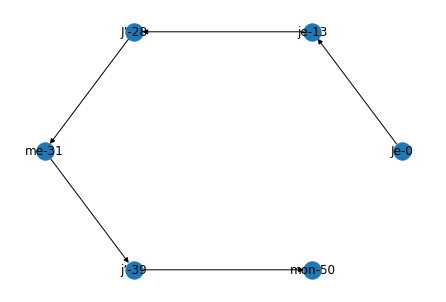

In [31]:
D = nx.DiGraph() # Dependency graph
S = nx.DiGraph() # String graph
N = nx.DiGraph() # Noun chunks graph
E = nx.DiGraph() # Emotion graph

n = 30 # spacing

 
# Create nodes containing token attributes

for token in doc:
    
    for i, sent in enumerate(doc.sents):
        if token.sent == sent:
            sent_i = i 
            sent_length = len(sent)
            
    # Display by number of sentences 
    
    #D.add_node(f'{token.text}-{token.i}', pos = (token.i % (sent_length + 1), len(list(doc.sents)) - sent_i), token={"lower": token.lower_, "lemma":token.lemma_, "dep":token.dep_, "pos":token.pos_, "morph":token.morph}, noun_chunk = "", isTerritoire = False, isAuteur = False, isModifieur = False, isNegation = False, isIndice = False, isAttaque = False, isCauseAttaque = False)
    
    # Display on only one line
    
    #D.add_node(f'{token.text}-{token.i}', pos = (token.i, 1), token={"lower": token.lower_, "lemma":token.lemma_, "dep":token.dep_, "pos":token.pos_, "morph":token.morph}, noun_chunk = "", isTerritoire = False, isAuteur = False, isModifieur = False, isNegation = False, isIndice = False, isAttaque = False, isCauseAttaque = False)
    
    # Multiple lines cropped
    
    D.add_node(f'{token.text}-{token.i}', pos = (token.i % n, token.i // n), token={"lower": token.lower_, "lemma":token.lemma_, "dep":token.dep_, "pos":token.pos_, "morph":token.morph}, noun_chunk = "", isTerritoire = False, isAuteur = False, isModifieur = False, isNegation = False, isIndice = False, isAttaque = False, isCauseAttaque = False)
    
    
# Create edges corresponding to the dependency graph
    
for token in doc:
    for child in token.children:
        D.add_edge(f'{token.text}-{token.i}', f'{child.text}-{child.i}', dep = child.dep_)
        
# Create edges corresponding to the string representation

for i, token in enumerate(doc):
    if (i+1) != len(doc):
        S.add_edge(f'{token.text}-{i}', f'{doc[i+1].text}-{i+1}')
        
# Create edges corresponding to the noun chunks

for nc in doc.noun_chunks:
    #print(nc.text)
    #print(D.nodes[f"{nc[0].text}-{nc[0].i}"]["pos"])
    
    # Display by number of sentences
    
    #N.add_node(f'{nc.text}', pos = ((nc.start+nc.end)//2 % (sent_length + 1), D.nodes[f"{nc[0].text}-{nc[0].i}"]["pos"][1] + 0.5), isTerritoire = False, isCauseAttaque = False)
    
    # Display on one line
    
    #N.add_node(f'{nc.text}', pos = ((nc.start+nc.end)//2, 2), isTerritoire = False, isCauseAttaque = False)
    
    # Multiple lines cropped
    
    N.add_node(f'{nc.text}', pos = (((nc.start+nc.end)//2)%n, D.nodes[f"{nc[0].text}-{nc[0].i}"]["pos"][1] + 0.5), isTerritoire = False, isCauseAttaque = False)
    
    for token in nc:
        D.nodes[f'{token.text}-{token.i}']["noun_chunk"] = f'{nc.text}'
        N.add_edge(f'{token.text}-{token.i}', f'{nc.text}')
        #i = token.i
        

C = nx.DiGraph() # Coreference graph
 
# Create edges corresponding to the coreference graph
ref_l = list()
for cluster in doc._.coref_clusters:
    
    ref = list()
    
    for i in cluster:
        if i[0] == i[1]:
            ref.append(f"{doc[i[0]].text}-{i[0]}")
        else:
            C.add_node(doc[i[0]:i[1]+1].text, pos = ((i[0]+i[1])//2, 2))
            ref.append(doc[i[0]:i[1]+1].text)
            
    ref_l.append(ref)
    
for ref in ref_l:
    for i, word in enumerate(ref):
        if i + 1 < len(ref):
            C.add_edge(ref[i], ref[i+1])
        
#T = nx.compose(S, C)
#T = nx.compose(D, S)
#T = nx.compose(T, N)


#pos = graphviz_layout(T, prog="dot")
#pos = nx.get_node_attributes(T,'pos')
pos = nx.drawing.layout.circular_layout(C)
nx.draw(C, pos, with_labels=True)
#plt.savefig("simple_path8.png") 

une sensation d’éveil
cette sensation
['Une-0', 'forme-1', 'd’-2', 'excitation-3', '.-4', 'J’-5', 'ai-6', 'ressenti-7', 'une-8', 'sensation-9', 'd’-10', 'éveil-11', '\xa0-12', '?-13', 'je-14', 'ne-15', 'connais-16', 'pas-17', 'cette-18', 'sensation-19', '\xa0-20', '?-21', 'tu-22', 'la-23', 'ressens-24', 'comment-25', '\xa0-26', '?-27', 'et-28', 'une-29', 'volonté-30', 'de-31', 'répondre-32', 'de-33', 'suite-34', '.-35', 'ce-36', 'n’-37', 'est-38', 'pas-39', 'un-40', 'ressenti-41', 'physique-42', ',-43', 'il-44', 'me-45', 'semble-46', '.-47', 'une sensation d’éveil', 'cette sensation']
NOUN
Une forme d’excitation.
Une forme d’excitation.
Une forme d’excitation.
Une forme d’excitation.
Une forme d’excitation.
J’
une sensation d’éveil
une sensation d’éveil
une sensation d’éveil
une sensation d’éveil
je
cette sensation
cette sensation
tu
la
et une volonté de répondre de suite.
et une volonté de répondre de suite.
et une volonté de répondre de suite.
et une volonté de répondre de suite.
et 

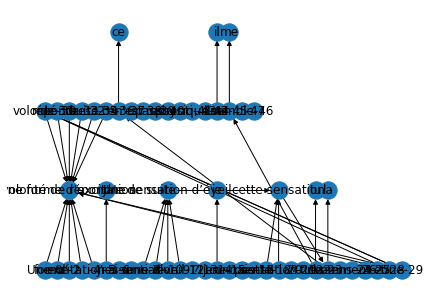

In [126]:
D = nx.DiGraph() # Dependency graph


n = 30 # spacing

 
# Create nodes containing token attributes

for token in doc:
    
    for i, sent in enumerate(doc.sents):
        if token.sent == sent:
            sent_i = i 
            sent_length = len(sent)
            
    # Display by number of sentences 
    
    #D.add_node(f'{token.text}-{token.i}', pos = (token.i % (sent_length + 1), len(list(doc.sents)) - sent_i), token={"lower": token.lower_, "lemma":token.lemma_, "dep":token.dep_, "pos":token.pos_, "morph":token.morph}, noun_chunk = "", isTerritoire = False, isAuteur = False, isModifieur = False, isNegation = False, isIndice = False, isAttaque = False, isCauseAttaque = False)
    
    # Display on only one line
    
    #D.add_node(f'{token.text}-{token.i}', pos = (token.i, 1), token={"lower": token.lower_, "lemma":token.lemma_, "dep":token.dep_, "pos":token.pos_, "morph":token.morph}, noun_chunk = "", isTerritoire = False, isAuteur = False, isModifieur = False, isNegation = False, isIndice = False, isAttaque = False, isCauseAttaque = False)
    
    # Multiple lines cropped
    
    D.add_node(f'{token.text}-{token.i}', pos = (token.i % n, token.i // n), token={"lower": token.lower_, "lemma":token.lemma_, "dep":token.dep_, "pos":token.pos_, "morph":token.morph})
    
    
# Create edges corresponding to the dependency graph
    
for token in doc:
    for child in token.children:
        D.add_edge(f'{token.text}-{token.i}', f'{child.text}-{child.i}', dep = child.dep_)
        
# Create edges corresponding to the string representation

for i, token in enumerate(doc):
    if (i+1) != len(doc):
        D.add_edge(f'{token.text}-{i}', f'{doc[i+1].text}-{i+1}')
        
 
# Create edges corresponding to the coreference graph

ref_l = list()
for cluster in doc._.coref_clusters:
    
    ref = list()
    
    for i in cluster:
        if i[0] == i[1]:
            ref.append(f"{doc[i[0]].text}-{i[0]}")
        else:
            if doc[i[0]:i[1]+1].text not in D:
                print(doc[i[0]:i[1]+1])
                D.add_node(doc[i[0]:i[1]+1].text)
            ref.append(doc[i[0]:i[1]+1].text)
            
    ref_l.append(ref)
    
for ref in ref_l:
    for i, word in enumerate(ref):
        if i + 1 < len(ref):
            D.add_edge(ref[i], ref[i+1])
            
print(D.nodes())
            

# Create edges corresponding to the noun chunks

print('NOUN')

for nc in doc.noun_chunks:
    #print(nc.text)
    #print(D.nodes[f"{nc[0].text}-{nc[0].i}"]["pos"])
    
    # Display by number of sentences
    
    #N.add_node(f'{nc.text}', pos = ((nc.start+nc.end)//2 % (sent_length + 1), D.nodes[f"{nc[0].text}-{nc[0].i}"]["pos"][1] + 0.5), isTerritoire = False, isCauseAttaque = False)
    
    # Display on one line
    
    #N.add_node(f'{nc.text}', pos = ((nc.start+nc.end)//2, 2), isTerritoire = False, isCauseAttaque = False)
    
    # Multiple lines cropped
    
    D.add_node(f'{nc.text}', pos = (((nc.start+nc.end)//2)%n, D.nodes[f"{nc[0].text}-{nc[0].i}"]["pos"][1] + 0.5))
    
    for token in nc:
        D.nodes[f'{token.text}-{token.i}']["noun_chunk"] = f'{nc.text}'
        print(nc.text)
        D.add_edge(f'{token.text}-{token.i}', f'{nc.text}')
        


#pos = graphviz_layout(T, prog="dot")
pos = nx.get_node_attributes(D,'pos')
#pos = nx.drawing.layout.circular_layout(D)
nx.draw(D, pos, with_labels=True)
#plt.savefig("simple_path8.png") 

In [32]:
def aspect_analysis(D, S, N, C, emotion_synonyms, attaque_synonyms):
    #initialize(D)
    #initialize(S)
    #initialize(N)
    initialize(C)
    applyAuteur(D)
    applyNegation(D)
    applyModifieur(D)
    applyIndice(D, emotion_synonyms)
    applyAttaque(D, N, attaque_synonyms)
    
    T = nx.compose(C, N)
    T = nx.compose(T, S)
    T = nx.compose(T, D)
    
    return T

T = aspect_analysis(D, S, N, C, emotion_synonyms, attaque_synonyms)

In [33]:
list(T.nodes.data())[0]

('Je-0',
 {'isNegation': False,
  'isAuteur': True,
  'isModifieur': False,
  'isIndice': False,
  'isAttaque': False,
  'isTerritoire': False,
  'isCauseAttaque': False,
  'pos': (0, 0),
  'token': {'lower': 'je',
   'lemma': 'je',
   'dep': 'nsubj',
   'pos': 'PRON',
   'morph': Number=Sing|Person=1},
  'noun_chunk': 'Je'})

In [34]:
def filter_auteur(n):
    return T.nodes[n]['isAuteur']

def filter_modifieur(n):
    return T.nodes[n]['isModifieur']

def filter_indice(n):
    return T.nodes[n]['isIndice']

def filter_negation(n):
    return T.nodes[n]['isNegation']

def filter_attaque(n):
    return T.nodes[n]['isAttaque']

def filter_territoire(n):
    return T.nodes[n]['isTerritoire']

def filter_causeattaque(n):
    return T.nodes[n]['isCauseAttaque']

auteur_view = nx.subgraph_view(D, filter_node=filter_auteur)

modifieur_view = nx.subgraph_view(D, filter_node=filter_modifieur)

indice_view = nx.subgraph_view(D, filter_node=filter_indice)

negation_view = nx.subgraph_view(D, filter_node=filter_negation)

attaque_view = nx.subgraph_view(D, filter_node=filter_attaque)

territoire_view = nx.subgraph_view(T, filter_node=filter_territoire)

causeattaque_view = nx.subgraph_view(T, filter_node=filter_causeattaque)

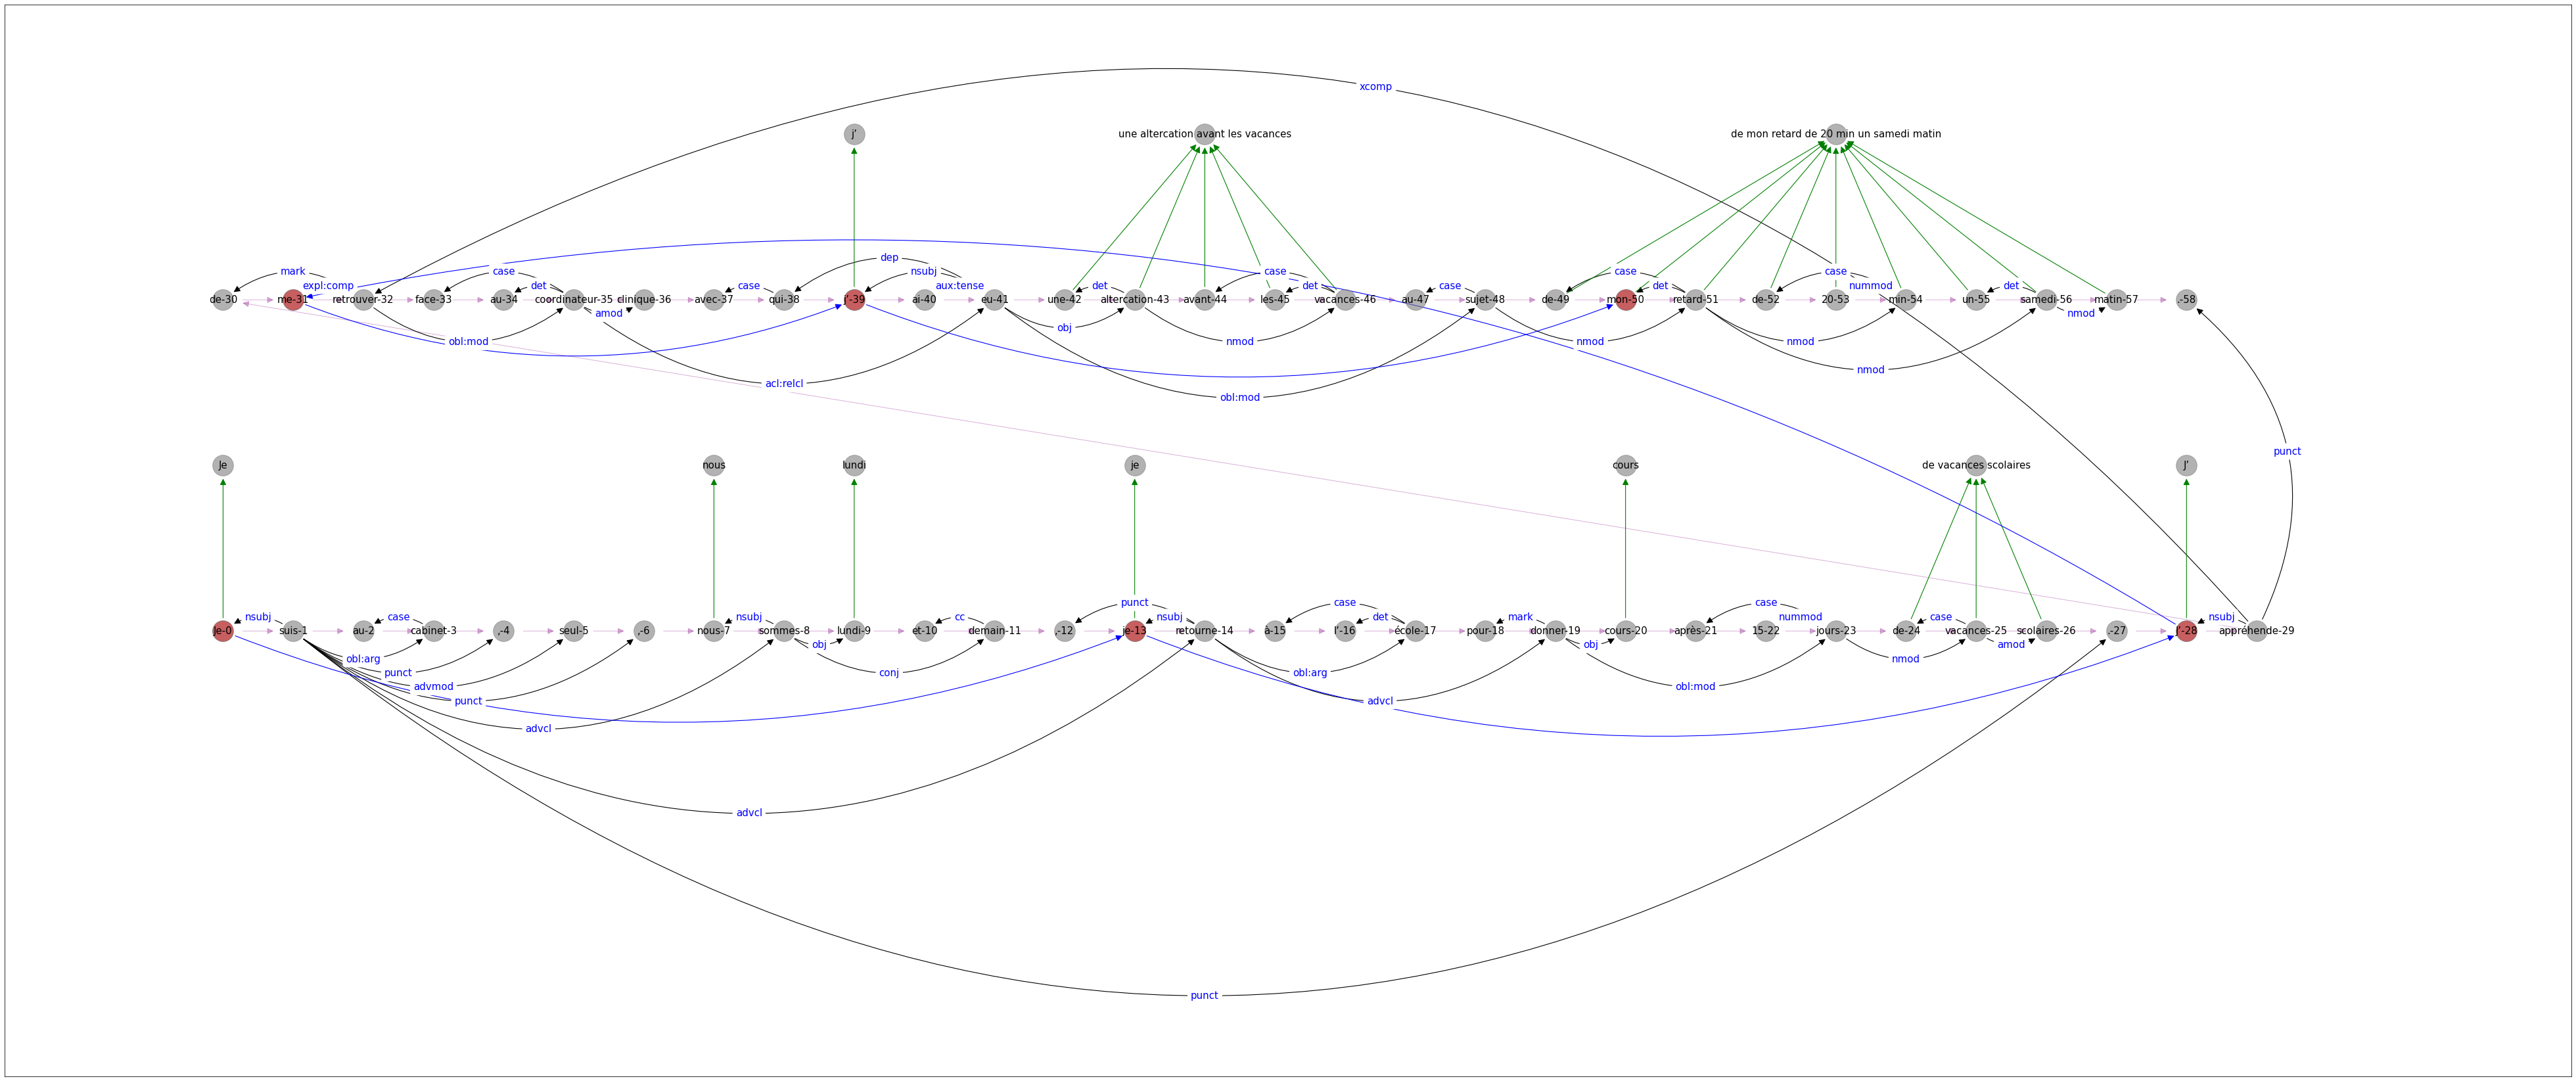

In [37]:
plt.figure(figsize=(70, 30))



options = {"edgecolors": "tab:gray", "node_size": 1000, "alpha": 0.6}
pos = nx.spring_layout(T) 
#pos = nx.planar_layout(T) 
#pos = nx.spectral_layout(T) 
#pos = nx.drawing.layout.circular_layout(T)
pos = nx.get_node_attributes(T,'pos')
#nx.draw_networkx_nodes(N, pos, nodelist=list(N.nodes), node_color="tab:red", **options)

#nx.draw(T, pos, connectionstyle="arc3,rad=0.5")   

nx.draw_networkx_nodes(T, pos, nodelist=list(T.nodes), node_color="tab:gray", **options)
nx.draw_networkx_nodes(T, pos, nodelist=list(auteur_view.nodes()), node_color="tab:red", **options)
nx.draw_networkx_nodes(T, pos, nodelist=list(modifieur_view.nodes()), node_color="tab:green", **options)
nx.draw_networkx_nodes(T, pos, nodelist=list(indice_view.nodes()), node_color="tab:blue", **options)
nx.draw_networkx_nodes(T, pos, nodelist=list(attaque_view.nodes()), node_color="tab:orange", **options)
nx.draw_networkx_nodes(T, pos, nodelist=list(territoire_view.nodes()), node_color="tab:purple", **options)
nx.draw_networkx_nodes(T, pos, nodelist=list(causeattaque_view.nodes()), node_color="tab:brown", **options)
edge_labels = nx.get_edge_attributes(T,'dep')

#my_draw_networkx_edge_labels(T, pos, edge_labels = edge_labels, font_size = 15, font_color = "blue")
nx.draw_networkx_edges(S, pos, arrowsize=20.0, width=1.0, alpha=0.3, min_target_margin = 30, min_source_margin = 30, edge_color = "purple", connectionstyle="arc3,rad=0.0")
nx.draw_networkx_edges(D, pos, arrowsize=20.0, width=1.1, alpha=1, min_target_margin = 20, min_source_margin = 20, connectionstyle="arc3,rad=0.4")
nx.draw_networkx_edges(N, pos, arrowsize=20.0, width=1.1, alpha=1, min_target_margin = 20, min_source_margin = 20, edge_color = "green", connectionstyle="arc3,rad=0.0")
nx.draw_networkx_edges(C, pos, arrowsize=20.0, width=1.1, alpha=1, min_target_margin = 20, min_source_margin = 20, edge_color = "blue", connectionstyle="arc3,rad=0.2")
nx.draw_networkx_labels(T, pos, font_size = 15)
my_draw_networkx_edge_labels(T, pos, edge_labels = edge_labels, font_size = 15, font_color = "blue", rotate=False, rad = 0.4)


#plt.savefig("mon_domaine_de_compétence.png")


plt.savefig('filename.png', bbox_inches='tight', dpi=100)
plt.show()

In [36]:
def my_draw_networkx_edge_labels(
    G,
    pos,
    edge_labels=None,
    label_pos=0.5,
    font_size=10,
    font_color="k",
    font_family="sans-serif",
    font_weight="normal",
    alpha=None,
    bbox=None,
    horizontalalignment="center",
    verticalalignment="center",
    ax=None,
    rotate=True,
    clip_on=True,
    rad=0
):
    """Draw edge labels.

    Parameters
    ----------
    G : graph
        A networkx graph

    pos : dictionary
        A dictionary with nodes as keys and positions as values.
        Positions should be sequences of length 2.

    edge_labels : dictionary (default={})
        Edge labels in a dictionary of labels keyed by edge two-tuple.
        Only labels for the keys in the dictionary are drawn.

    label_pos : float (default=0.5)
        Position of edge label along edge (0=head, 0.5=center, 1=tail)

    font_size : int (default=10)
        Font size for text labels

    font_color : string (default='k' black)
        Font color string

    font_weight : string (default='normal')
        Font weight

    font_family : string (default='sans-serif')
        Font family

    alpha : float or None (default=None)
        The text transparency

    bbox : Matplotlib bbox, optional
        Specify text box properties (e.g. shape, color etc.) for edge labels.
        Default is {boxstyle='round', ec=(1.0, 1.0, 1.0), fc=(1.0, 1.0, 1.0)}.

    horizontalalignment : string (default='center')
        Horizontal alignment {'center', 'right', 'left'}

    verticalalignment : string (default='center')
        Vertical alignment {'center', 'top', 'bottom', 'baseline', 'center_baseline'}

    ax : Matplotlib Axes object, optional
        Draw the graph in the specified Matplotlib axes.

    rotate : bool (deafult=True)
        Rotate edge labels to lie parallel to edges

    clip_on : bool (default=True)
        Turn on clipping of edge labels at axis boundaries

    Returns
    -------
    dict
        `dict` of labels keyed by edge

    Examples
    --------
    >>> G = nx.dodecahedral_graph()
    >>> edge_labels = nx.draw_networkx_edge_labels(G, pos=nx.spring_layout(G))

    Also see the NetworkX drawing examples at
    https://networkx.org/documentation/latest/auto_examples/index.html

    See Also
    --------
    draw
    draw_networkx
    draw_networkx_nodes
    draw_networkx_edges
    draw_networkx_labels
    """
    import matplotlib.pyplot as plt
    import numpy as np

    if ax is None:
        ax = plt.gca()
    if edge_labels is None:
        labels = {(u, v): d for u, v, d in G.edges(data=True)}
    else:
        labels = edge_labels
    text_items = {}
    for (n1, n2), label in labels.items():
        (x1, y1) = pos[n1]
        (x2, y2) = pos[n2]
        (x, y) = (
            x1 * label_pos + x2 * (1.0 - label_pos),
            y1 * label_pos + y2 * (1.0 - label_pos),
        )
        pos_1 = ax.transData.transform(np.array(pos[n1]))
        pos_2 = ax.transData.transform(np.array(pos[n2]))
        linear_mid = 0.5*pos_1 + 0.5*pos_2
        d_pos = pos_2 - pos_1
        rotation_matrix = np.array([(0,1), (-1,0)])
        ctrl_1 = linear_mid + rad*rotation_matrix@d_pos
        ctrl_mid_1 = 0.5*pos_1 + 0.5*ctrl_1
        ctrl_mid_2 = 0.5*pos_2 + 0.5*ctrl_1
        bezier_mid = 0.5*ctrl_mid_1 + 0.5*ctrl_mid_2
        (x, y) = ax.transData.inverted().transform(bezier_mid)

        if rotate:
            # in degrees
            angle = np.arctan2(y2 - y1, x2 - x1) / (2.0 * np.pi) * 360
            # make label orientation "right-side-up"
            if angle > 90:
                angle -= 180
            if angle < -90:
                angle += 180
            # transform data coordinate angle to screen coordinate angle
            xy = np.array((x, y))
            trans_angle = ax.transData.transform_angles(
                np.array((angle,)), xy.reshape((1, 2))
            )[0]
        else:
            trans_angle = 0.0
        # use default box of white with white border
        if bbox is None:
            bbox = dict(boxstyle="round", ec=(1.0, 1.0, 1.0), fc=(1.0, 1.0, 1.0))
        if not isinstance(label, str):
            label = str(label)  # this makes "1" and 1 labeled the same

        t = ax.text(
            x,
            y,
            label,
            size=font_size,
            color=font_color,
            family=font_family,
            weight=font_weight,
            alpha=alpha,
            horizontalalignment=horizontalalignment,
            verticalalignment=verticalalignment,
            rotation=trans_angle,
            transform=ax.transData,
            bbox=bbox,
            zorder=1,
            clip_on=clip_on,
        )
        text_items[(n1, n2)] = t

    ax.tick_params(
        axis="both",
        which="both",
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False,
    )

    return text_items